# Notebook 3 - Model baseline

### 1. Setup constants

In [1]:
# Constants
data_original_dir = 'data_original'
data_processed_dir = 'data_processed'
split_dirs = ['train', 'test', 'validation']
diagnostic_classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
img_format = 'jpg'

labels = [4, 6, 2, 1, 0, 5, 3]
label_name = {x: y for x, y in zip(labels, diagnostic_classes)}

sorted_labels, sorted_diagnostic_classes = (list(t) for t in zip(*sorted(zip(labels, diagnostic_classes))))

In [4]:
sorted_labels
sorted_diagnostic_classes

[0, 1, 2, 3, 4, 5, 6]

['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']

### 2. Imports and notebook setup

In [3]:
# Set up multiple outputs for cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Printing with markdown
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Default imports
import os
import random
import shutil
from glob import glob
from send2trash import send2trash
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Magics
%matplotlib inline

In [4]:
data_processed_dir_path = os.path.join('..', data_processed_dir)
data_original_dir_path = os.path.join('..', data_original_dir)

train_path = os.path.join(data_processed_dir_path, split_dirs[0])
test_path = os.path.join(data_processed_dir_path, split_dirs[1])
val_path = os.path.join(data_processed_dir_path, split_dirs[2])

### 3. Read data

In [5]:
file_rgb = 'hmnist_28_28_RGB.csv'
file_gray = 'hmnist_28_28_L.csv'
file_reference = 'HAM10000_metadata.csv'

In [6]:
df_rgb = pd.read_csv(os.path.join(data_original_dir_path, file_rgb))
df_gray = pd.read_csv(os.path.join(data_original_dir_path, file_gray))
df_ref = pd.read_csv(os.path.join(data_original_dir_path, file_reference))

In [7]:
df_rgb.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [8]:
df_rgb.label.value_counts()
df_ref.dx.value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [9]:
df_ref.dx.value_counts() / len(df_ref)

nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64

### 4. Train test split

In [10]:
# Setting random seed for the split
random.seed(100)

# We're splitting on lesion_id to avoid data leakage
test_rate = 0.25
lesions = df_ref.lesion_id.unique().tolist()
test_size = round(test_rate * len(lesions))

test_lesions = random.sample(population=lesions, k=test_size)
test_indices = df_ref[df_ref.lesion_id.isin(test_lesions)].index
train_indices = df_ref[~df_ref.lesion_id.isin(test_lesions)].index

In [11]:
df_rgb_train = df_rgb.iloc[train_indices, :]
df_rgb_test = df_rgb.iloc[test_indices, :]

df_gray_train = df_gray.iloc[train_indices, :]
df_gray_test = df_gray.iloc[test_indices, :]

In [12]:
# RGB
X_rgb_train = df_rgb_train.drop('label', axis=1)
y_rgb_train = df_rgb_train['label']

X_rgb_test = df_rgb_test.drop('label', axis=1)
y_rgb_test = df_rgb_test['label']

# GRAY
X_gray_train = df_gray_train.drop('label', axis=1)
y_gray_train = df_gray_train['label']

X_gray_test = df_gray_test.drop('label', axis=1)
y_gray_test = df_gray_test['label']

### 5. Define plot function

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        pass
#         print('Confusion matrix, without normalization')

#     print(cm.sum(axis=1))

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    _ = ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    _ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### 6. Fit models

In [14]:
np.set_printoptions(precision=2)
# # Plot non-normalized confusion matrix
# _ = plot_confusion_matrix(y_true=y_rgb_test, y_pred=predictions, classes=np.array(names),
#                       title='Confusion matrix, without normalization')
# # Plot normalized confusion matrix
# _ = plot_confusion_matrix(y_true=y_rgb_test, y_pred=predictions, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
# plt.show()

#### 6.1 KNN - RGB

In [15]:
for n_neighbors in range(1, 26):
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
    _ = knn_clf.fit(X_rgb_train, y_rgb_train)
    predictions = knn_clf.predict(X_rgb_test)
    print('n_neighbors:', n_neighbors, 'acc:', sklearn.metrics.accuracy_score(y_true=y_rgb_test, y_pred=predictions))

n_neighbors: 1 acc: 0.6572807723250201
n_neighbors: 2 acc: 0.6444086886564763
n_neighbors: 3 acc: 0.671761866452132
n_neighbors: 4 acc: 0.6773934030571199
n_neighbors: 5 acc: 0.6810136765888978
n_neighbors: 6 acc: 0.6906677393403057
n_neighbors: 7 acc: 0.6914722445695897
n_neighbors: 8 acc: 0.6914722445695897
n_neighbors: 9 acc: 0.6938857602574416
n_neighbors: 10 acc: 0.6958970233306516
n_neighbors: 11 acc: 0.6995172968624296
n_neighbors: 12 acc: 0.6999195494770716
n_neighbors: 13 acc: 0.6991150442477876
n_neighbors: 14 acc: 0.7003218020917136
n_neighbors: 15 acc: 0.6999195494770716
n_neighbors: 16 acc: 0.6999195494770716
n_neighbors: 17 acc: 0.7023330651649236
n_neighbors: 18 acc: 0.7031375703942075
n_neighbors: 19 acc: 0.7027353177795655
n_neighbors: 20 acc: 0.7007240547063556
n_neighbors: 21 acc: 0.6995172968624296
n_neighbors: 22 acc: 0.7007240547063556
n_neighbors: 23 acc: 0.6991150442477876
n_neighbors: 24 acc: 0.7007240547063556
n_neighbors: 25 acc: 0.6991150442477876


In [28]:
knn_clf = KNeighborsClassifier(n_neighbors=18, n_jobs=-1)
_ = knn_clf.fit(X_rgb_train, y_rgb_train)
predictions = knn_clf.predict(X_rgb_test)
sklearn.metrics.accuracy_score(y_true=y_rgb_test, y_pred=predictions)

0.7031375703942075

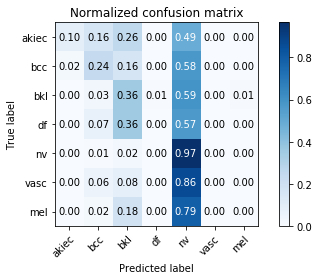

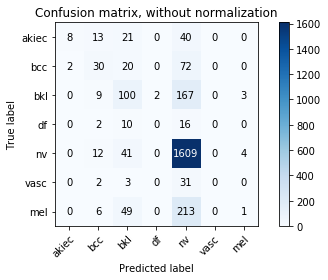

In [29]:
_ = plot_confusion_matrix(y_true=y_rgb_test, y_pred=predictions, 
                          classes=np.array(sorted_diagnostic_classes), normalize=True)
_ = plot_confusion_matrix(y_true=y_rgb_test, y_pred=predictions, classes=np.array(sorted_diagnostic_classes))

#### 6.2 KNN - Gray

In [18]:
for n_neighbors in range(1, 26):
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
    _ = knn_clf.fit(X_gray_train, y_gray_train)
    predictions = knn_clf.predict(X_gray_test)
    print('n_neighbors:', n_neighbors, 'acc:', sklearn.metrics.accuracy_score(y_true=y_gray_test, y_pred=predictions))

n_neighbors: 1 acc: 0.6323411102172164
n_neighbors: 2 acc: 0.6351568785197104
n_neighbors: 3 acc: 0.665728077232502
n_neighbors: 4 acc: 0.672566371681416
n_neighbors: 5 acc: 0.674175382139984
n_neighbors: 6 acc: 0.6790024135156878
n_neighbors: 7 acc: 0.6826226870474658
n_neighbors: 8 acc: 0.6810136765888978
n_neighbors: 9 acc: 0.6842316975060337
n_neighbors: 10 acc: 0.6858407079646017
n_neighbors: 11 acc: 0.6858407079646017
n_neighbors: 12 acc: 0.6894609814963797
n_neighbors: 13 acc: 0.6890587288817377
n_neighbors: 14 acc: 0.6858407079646017
n_neighbors: 15 acc: 0.6878519710378117
n_neighbors: 16 acc: 0.6842316975060337
n_neighbors: 17 acc: 0.6862429605792437
n_neighbors: 18 acc: 0.6846339501206757
n_neighbors: 19 acc: 0.6838294448913917
n_neighbors: 20 acc: 0.6858407079646017
n_neighbors: 21 acc: 0.6846339501206757
n_neighbors: 22 acc: 0.6862429605792437
n_neighbors: 23 acc: 0.6850362027353177
n_neighbors: 24 acc: 0.6842316975060337
n_neighbors: 25 acc: 0.6854384553499597


In [19]:
knn_clf = KNeighborsClassifier(n_neighbors=12, n_jobs=-1)
_ = knn_clf.fit(X_gray_train, y_gray_train)
predictions = knn_clf.predict(X_gray_test)
sklearn.metrics.accuracy_score(y_true=y_gray_test, y_pred=predictions)

0.6894609814963797

#### 6.3 Logistic Regression - RGB

In [30]:
lr_clf = LogisticRegression(n_jobs=-1, solver='lbfgs')
lr_clf.fit(X_rgb_train, y_rgb_train)
predictions = lr_clf.predict(X_rgb_test)
sklearn.metrics.accuracy_score(y_true=y_rgb_test, y_pred=predictions)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

0.6874497184231697

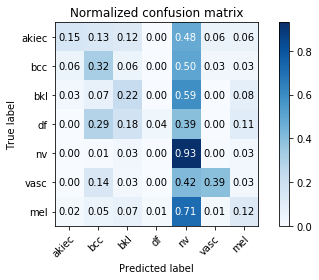

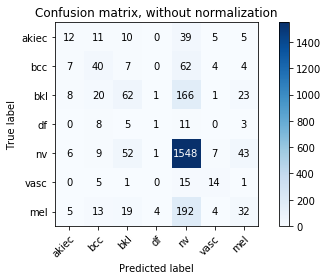

In [31]:
_ = plot_confusion_matrix(y_true=y_rgb_test, y_pred=predictions, 
                          classes=np.array(sorted_diagnostic_classes), normalize=True)
_ = plot_confusion_matrix(y_true=y_rgb_test, y_pred=predictions, classes=np.array(sorted_diagnostic_classes))

#### 6.4 Logistic Regression - Gray

In [22]:
lr_clf = LogisticRegression(n_jobs=-1, solver='lbfgs')
lr_clf.fit(X_gray_train, y_gray_train)
predictions = lr_clf.predict(X_gray_test)
sklearn.metrics.accuracy_score(y_true=y_gray_test, y_pred=predictions)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

0.673773129525342

### 6.5 Random Forest - RGB

In [23]:
np.set_printoptions(precision=4)

for n_estimators in [3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 150, 200]:
    accs = []
    print('n_estimators:', n_estimators)
    for max_depth in [2, 3, 5, 7, 10, 25, 50, 75, 100, 150]:
        rf_clf = RandomForestClassifier(class_weight='balanced', n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)
        _ = rf_clf.fit(X_rgb_train, y_rgb_train)
        predictions = rf_clf.predict(X_rgb_test)
        accs.append(sklearn.metrics.accuracy_score(y_true=y_rgb_test, y_pred=predictions))
    print(np.array(accs))

n_estimators: 3
[0.3878 0.3789 0.4505 0.4964 0.5708 0.6279 0.6219 0.6219 0.6219 0.6219]
n_estimators: 4
[0.3821 0.3777 0.4549 0.5012 0.5845 0.6521 0.6553 0.6553 0.6553 0.6553]
n_estimators: 5
[0.4167 0.4091 0.4702 0.5121 0.5909 0.6593 0.6693 0.6693 0.6693 0.6693]
n_estimators: 6
[0.428  0.4183 0.4646 0.5209 0.5986 0.673  0.6762 0.6762 0.6762 0.6762]
n_estimators: 7
[0.4513 0.4332 0.4787 0.5278 0.599  0.6673 0.6774 0.6774 0.6774 0.6774]
n_estimators: 8
[0.434  0.4324 0.4803 0.5322 0.6002 0.6774 0.6854 0.6854 0.6854 0.6854]
n_estimators: 9
[0.4429 0.4368 0.4803 0.5338 0.6042 0.683  0.6846 0.6846 0.6846 0.6846]
n_estimators: 10
[0.4461 0.4421 0.4835 0.5358 0.6058 0.6858 0.6891 0.6891 0.6891 0.6891]
n_estimators: 50
[0.4372 0.4582 0.4988 0.5535 0.6287 0.6939 0.7003 0.7003 0.7003 0.7003]
n_estimators: 100
[0.4324 0.4682 0.4968 0.5527 0.6376 0.6995 0.7011 0.7011 0.7011 0.7011]
n_estimators: 150
[0.4381 0.4718 0.4984 0.5547 0.6344 0.6995 0.7003 0.7003 0.7003 0.7003]
n_estimators: 200
[0.4336 

In [32]:
rf_clf = RandomForestClassifier(class_weight='balanced', n_estimators=50, max_depth=50, n_jobs=-1, random_state=42)
_ = rf_clf.fit(X_rgb_train, y_rgb_train)
predictions = rf_clf.predict(X_rgb_test)
sklearn.metrics.accuracy_score(y_true=y_rgb_test, y_pred=predictions)

0.7003218020917136

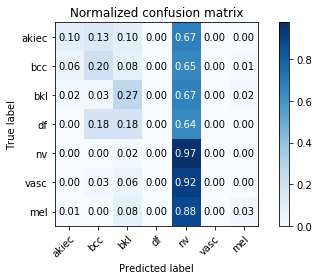

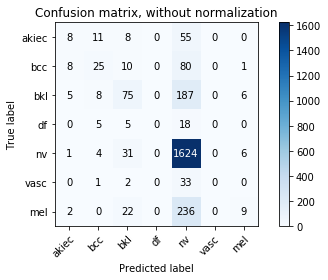

In [33]:
_ = plot_confusion_matrix(y_true=y_rgb_test, y_pred=predictions, 
                          classes=np.array(sorted_diagnostic_classes), normalize=True)
_ = plot_confusion_matrix(y_true=y_rgb_test, y_pred=predictions, classes=np.array(sorted_diagnostic_classes))

### 6.5 Random Forest - Gray

In [26]:
np.set_printoptions(precision=4)

for n_estimators in [3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 150]:
    accs = []
    print('n_estimators:', n_estimators)
    for max_depth in [2, 3, 5, 7, 10, 25, 50, 75, 100]:
        rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)
        _ = rf_clf.fit(X_gray_train, y_gray_train)
        predictions = rf_clf.predict(X_gray_test)
        accs.append(sklearn.metrics.accuracy_score(y_true=y_rgb_test, y_pred=predictions))
    print(np.array(accs))

n_estimators: 3
[0.6738 0.6758 0.6854 0.6758 0.6706 0.6219 0.5949 0.5949 0.5949]
n_estimators: 4
[0.6702 0.675  0.6826 0.6818 0.6738 0.636  0.6295 0.6295 0.6295]
n_estimators: 5
[0.6702 0.6742 0.6838 0.6798 0.6846 0.6649 0.6496 0.6468 0.6468]
n_estimators: 6
[0.6702 0.6746 0.6842 0.679  0.6883 0.6577 0.6641 0.6569 0.6569]
n_estimators: 7
[0.6702 0.6742 0.683  0.6818 0.6874 0.6698 0.6665 0.6669 0.6669]
n_estimators: 8
[0.6702 0.6734 0.6826 0.6846 0.6874 0.673  0.6698 0.6738 0.6738]
n_estimators: 9
[0.6702 0.6726 0.6834 0.6822 0.6846 0.6734 0.6762 0.679  0.679 ]
n_estimators: 10
[0.6702 0.6734 0.683  0.6818 0.6899 0.6814 0.6802 0.6838 0.6838]
n_estimators: 50
[0.6702 0.6726 0.6806 0.6854 0.6943 0.6927 0.6967 0.6959 0.6959]
n_estimators: 100
[0.6702 0.6714 0.6818 0.6838 0.6963 0.6927 0.6935 0.6935 0.6935]
n_estimators: 150
[0.6702 0.6714 0.6818 0.6842 0.6935 0.6959 0.6959 0.6947 0.6947]


In [27]:
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=50, n_jobs=-1, random_state=42)
rf_clf.fit(X_gray_train, y_gray_train)
_ = predictions = rf_clf.predict(X_gray_test)
sklearn.metrics.accuracy_score(y_true=y_gray_test, y_pred=predictions)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

0.6967015285599356